# Workflow Interface 103 - Cyclic Institutional Incremental Learning
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_103_Cyclic_Institutional_Incremental_Learning.ipynb)

In this tutorial, we build demonstrate how to cyclic institutional incremental learning using the workflow interface, where each collaborator passes it's locally trained model to the next collaborator as follows:

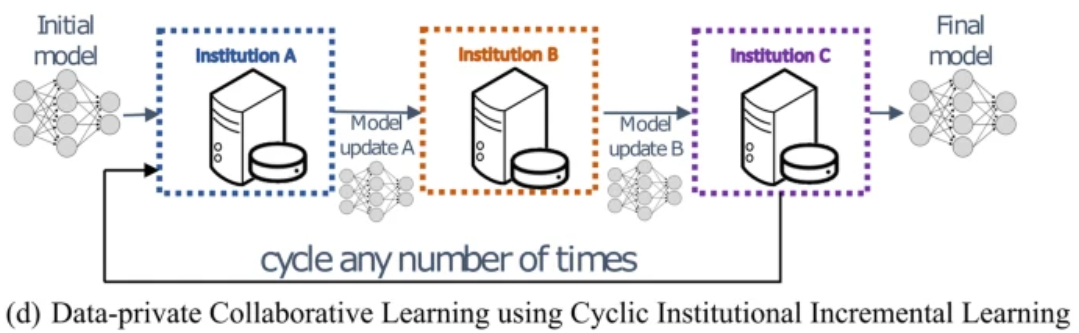
diagram from [msheller 2020](https://www.nature.com/articles/s41598-020-69250-1))

Instead of passing the model directly from collaborator to collaborator (col1->col2), the aggregator will serve as a go-between (col1->agg->col2), but the effect will be the same. 

# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [ ]:
!pip install git+https://github.com/securefederatedai/openfl.git
!pip install -r workflow_interface_requirements.txt
!pip install torch
!pip install torchvision

# Uncomment this if running in Google Colab
#!pip install -r https://raw.githubusercontent.com/intel/openfl/develop/openfl-tutorials/experimental/workflow_interface_requirements.txt
#import os
#os.environ["USERNAME"] = "colab"

We begin with the quintessential example of a small pytorch CNN model trained on the MNIST dataset. Let's start define our dataloaders, model, optimizer, and some helper functions like we would for any other deep learning experiment

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import numpy as np

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

mnist_train = torchvision.datasets.MNIST('files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

mnist_test = torchvision.datasets.MNIST('files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
def inference(network,test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = network(data)
        test_loss += F.nll_loss(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
    accuracy = float(correct / len(test_loader.dataset))
    return accuracy

Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [ ]:
from copy import deepcopy

from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator


def FedAvg(models, weights=None):
    new_model = models[0]
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = torch.from_numpy(np.average([state[key].numpy() for state in state_dicts],
                                                      axis=0, 
                                                      weights=weights))
    new_model.load_state_dict(state_dict)
    return new_model


Now we come to the updated flow definition. Here we use the same tasks as the [quickstart](https://github.com/psfoley/openfl/blob/experimental-workflow-interface/openfl-tutorials/experimental/Workflow_Interface_MNIST.ipynb), but give the aggregator a `test_loader` as a private attribute. The aggregator will do a forward pass on each of the aggregator's models using it's validation data, and weight the highest accuracy model higher than others.  

In [ ]:
class CyclicLearningFlow(FLSpec):

    def __init__(self, model = None, optimizer = None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            self.model = Net()
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        self.rounds = rounds

    @aggregator
    def start(self):
        print('Performing cyclic institutional incremental learning')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        print(f'Starting round {self.current_round}...')
        # col_idx tracks the current collaborator 
        self.col_idx = 0
        self.next(self.select_next_collaborator)
        
    @aggregator
    def select_next_collaborator(self):
        self.collaborators = self.runtime.collaborators
        self.next_collaborator = [self.collaborators[self.col_idx]]
        self.next(self.aggregated_model_validation,foreach='next_collaborator',exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model,self.test_loader)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.model.train()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        train_losses = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()
          if batch_idx % log_interval == 0:
            print('Train Epoch: 1 [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
               batch_idx * len(data), len(self.train_loader.dataset),
              100. * batch_idx / len(self.train_loader), loss.item()))
            self.loss = loss.item()
            torch.save(self.model.state_dict(), 'model.pth')
            torch.save(self.optimizer.state_dict(), 'optimizer.pth')
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model,self.test_loader)
        print(f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self,inputs):
        self.average_loss = sum(input.loss for input in inputs)/len(inputs)
        self.aggregated_model_accuracy = sum(input.agg_validation_score for input in inputs)/len(inputs)
        self.local_model_accuracy = sum(input.local_validation_score for input in inputs)/len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        
        # We take local validation score because it represents accuracy after training that collaborator's model
        self.accuracy = inputs[0].local_validation_score
        print(f'Accuracy after training on {inputs[0].input}  = {self.accuracy}')
        
        # No aggregation function is performed because the passed model is updated directly
        self.model = inputs[0].model
        
        if self.col_idx < (len(self.collaborators) - 1):
            self.col_idx += 1
        else:
            self.current_round += 1
            self.col_idx = 0
            
            print(f'Starting round {self.current_round}...')
            
        if self.current_round < self.rounds:
            self.next(self.select_next_collaborator)
        else:
            self.next(self.end)
        
    @aggregator
    def end(self):
        print(f'\nfinal model accuracy = {self.accuracy}')
        print(f'This is the end of the flow')  

You'll notice in the `CyclicFlow` definition above that each collaborator performs **aggregated_model_validation**, **training**, and **local_model_validation** before passing it's model on to the next collaborator (through the aggregator)

Let's define the Participants and runtime now ! Each participant has it's own set of private attributes which can be set using callback function while instantiating the participant. The callback function returns the private attributes in form of a dictionary where the key is the attribute name, and the value is the object that will be made accessible to that participant's task

Callback function, `callable_to_initialize_aggregator_private_attributes`, returns the private attribute `test_loader` of the Aggregator.

Callback function, `callable_to_initialize_collaborator_private_attributes`, segment shards of the MNIST dataset for four collaborators: `Portland`, `Seattle`, `Chandler`, and `Bangalore` and returns the private attribute `train_loader` and `test_loader`

In [ ]:
collaborator_names = ['Portland', 'Seattle','Chandler','Bangalore']

def callable_to_initialize_aggregator_private_attributes(n_collaborators, test_dataset,
        batch_size):
    aggregator_test = deepcopy(test_dataset)
    aggregator_test.targets = test_dataset.targets[n_collaborators::n_collaborators+1]
    aggregator_test.data = test_dataset.data[n_collaborators::n_collaborators+1]

    return {
        'test_loader': torch.utils.data.DataLoader(aggregator_test, batch_size=batch_size, shuffle=True)
    }

# Setup Aggregator private attributes via callable function
agg = Aggregator(
    name="agg",
    private_attributes_callable=callable_to_initialize_aggregator_private_attributes,
    n_collaborators=len(collaborator_names), test_dataset=mnist_test,
    batch_size=batch_size_test
)

def callable_to_initialize_collaborator_private_attributes(index, n_collaborators,
        batch_size_train, train_dataset, test_dataset):
    local_train = deepcopy(train_dataset)
    local_test = deepcopy(test_dataset)
    local_train.data = train_dataset.data[index::n_collaborators]
    local_train.targets = train_dataset.targets[index::n_collaborators]
    local_test.data = test_dataset.data[index::n_collaborators+1]
    local_test.targets = test_dataset.targets[index::n_collaborators+1]

    return {
        'train_loader': torch.utils.data.DataLoader(local_train, batch_size=batch_size_train, shuffle=True),
        'test_loader': torch.utils.data.DataLoader(local_test, batch_size=batch_size_train, shuffle=True)
    }

# Setup collaborators private attributes via callable function
collaborators=[]
for idx, collaborator_name in enumerate(collaborator_names):
    collaborators.append(
        Collaborator(   
            name=collaborator_name, num_cpus=0, num_gpus=0,
            private_attributes_callable=callable_to_initialize_collaborator_private_attributes,
            index=idx, n_collaborators=len(collaborator_names), batch_size_train=batch_size_train,
            train_dataset=mnist_train, test_dataset=mnist_test
        )
    )

local_runtime = LocalRuntime(aggregator=agg, collaborators=collaborators, backend='ray') 
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Now that we have our flow and runtime defined, let's run the experiment! 

In [ ]:
model = None
best_model = None
optimizer = None
clflow = CyclicLearningFlow(model,optimizer)
clflow.runtime = local_runtime
clflow.run()

You should see the CyclicFlow produce final accuracy > 95%. Let's see how an equivalent federated learning flow performs in comparison.

In [ ]:
class FederatedFlow(FLSpec):

    def __init__(self, model = None, optimizer = None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            self.optimizer = optimizer
        else:
            self.model = Net()
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        self.rounds = rounds

    @aggregator
    def start(self):
        print(f'Performing initialization for model')
        self.collaborators = self.runtime.collaborators
        self.private = 10
        self.current_round = 0
        self.next(self.aggregated_model_validation,foreach='collaborators',exclude=['private'])

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model,self.test_loader)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.model.train()
        self.weight = len(self.train_loader)
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate,
                                   momentum=momentum)
        train_losses = []
        for batch_idx, (data, target) in enumerate(self.train_loader):
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()
          if batch_idx % log_interval == 0:
            print('Train Epoch: 1 [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
               batch_idx * len(data), len(self.train_loader.dataset),
              100. * batch_idx / len(self.train_loader), loss.item()))
            self.loss = loss.item()
            torch.save(self.model.state_dict(), 'model.pth')
            torch.save(self.optimizer.state_dict(), 'optimizer.pth')
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model,self.test_loader)
        print(f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=['training_completed'])

    @aggregator
    def join(self,inputs):
        weights = np.array([float(input.weight) for input in inputs])
        weights /= sum(weights)
        self.average_loss = np.average([input.loss for input in inputs],axis=0,weights=weights)
        self.aggregated_model_accuracy = np.average([input.agg_validation_score for input in inputs],axis=0,weights=weights)
        self.local_model_accuracy = np.average([input.local_validation_score for input in inputs],axis=0,weights=weights)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')

        self.model = FedAvg([input.model for input in inputs],weights=weights)
        self.optimizer = [input.optimizer for input in inputs][0]
        self.current_round += 1
                                                                 
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])
        else:
            self.final_accuracy = self.aggregated_model_accuracy
            self.next(self.end)
        
    @aggregator
    def end(self):
        print(f'\nfinal model accuracy = {self.final_accuracy}')
        print(f'This is the end of the flow')  

In [ ]:
model = None
best_model = None
optimizer = None
flflow = FederatedFlow(model,optimizer)
flflow.runtime = local_runtime
flflow.run()

In the case of highly IID (independent and identically distributed) data, we see the cyclic instutitional incremental learning approach outperform FL, but lets compare the approaches when the number of samples and representation of classes starts to diverge between collaborators.

In [ ]:
collaborator_names = ['Portland', 'Seattle', 'Chandler','Bangalore']

def callable_to_initialize_aggregator_private_attributes(n_collaborators, test_dataset, batch_size):
    aggregator_test = deepcopy(test_dataset)
    aggregator_test.targets = test_dataset.targets[n_collaborators::n_collaborators+1]
    aggregator_test.data = test_dataset.data[n_collaborators::n_collaborators+1]

    return {
        'test_loader': torch.utils.data.DataLoader(aggregator_test, batch_size=batch_size, shuffle=True)
    }

# Setup Aggregator private attributes via callable function
agg = Aggregator(
    name="agg",
    private_attributes_callable=callable_to_initialize_aggregator_private_attributes,
    n_collaborators = len(collaborator_names), test_dataset=mnist_test,
    batch_size=batch_size_test
)

def callable_to_initialize_collaborator_private_attributes(index, collaborator_name, n_collaborators, batch_size_train, train_dataset, test_dataset):
    local_train = deepcopy(train_dataset)
    local_test = deepcopy(test_dataset)
    local_train.data = train_dataset.data[index::n_collaborators]
    local_train.targets = train_dataset.targets[index::n_collaborators]
    if collaborator_name == 'Portland':
        # Remove the 0 class from Portland
        mask = local_train.targets != 1
        local_train.data = local_train.data[mask]
        local_train.targets = local_train.targets[mask]
    if collaborator_name == 'Seattle':
        # Seattle has 500 samples of class 1 (exclusively)
        mask = local_train.targets == 1
        local_train.data = local_train.data[mask]
        local_train.targets = local_train.targets[mask]
        local_train.data = local_train.data[:500]
        local_train.targets = local_train.targets[:500]
    if collaborator_name == 'Chandler':
        # Chandler has 300 samples of class 2 (exclusively)
        mask = local_train.targets == 2
        local_train.data = local_train.data[mask]
        local_train.targets = local_train.targets[mask]
        local_train.data = local_train.data[:300]
        local_train.targets = local_train.targets[:300]
    if collaborator_name == 'Bangalore':
        # Bangalore has 300 samples of class 3 (exclusively)
        mask = local_train.targets == 3
        local_train.data = local_train.data[mask]
        local_train.targets = local_train.targets[mask]
        local_train.data = local_train.data[:500]
        local_train.targets = local_train.targets[:500]
    # Test data is left unchanged (all classes represented)
    local_test.data = test_dataset.data[index::n_collaborators+1]
    local_test.targets = test_dataset.targets[index::n_collaborators+1]
    return {
        'train_loader': torch.utils.data.DataLoader(local_train,batch_size=batch_size_train, shuffle=True),
        'test_loader': torch.utils.data.DataLoader(local_test,batch_size=batch_size_train, shuffle=True)
    }

# Setup collaborators private attributes via callable function
collaborators=[]
for idx, collaborator_name in enumerate(collaborator_names):
    collaborators.append(
        Collaborator(
            name=collaborator_name, num_cpus=0, num_gpus=0,
            private_attributes_callable=callable_to_initialize_collaborator_private_attributes,
            index=idx, collaborator_name=collaborator_name, n_collaborators=len(collaborator_names),
            batch_size_train=batch_size_train, train_dataset=mnist_train, test_dataset=mnist_test,
        )
    )

local_runtime = LocalRuntime(aggregator=agg, collaborators=collaborators, backend='ray')
print(f'Local runtime collaborators = {local_runtime.collaborators}')

In [ ]:
model = None
best_model = None
optimizer = None
clflow2 = CyclicLearningFlow(model, optimizer, rounds=4)
clflow2.runtime = local_runtime
clflow2.run()

In [ ]:
model = None
best_model = None
optimizer = None
flflow2 = FederatedFlow(model, optimizer, rounds=4)
flflow2.runtime = local_runtime
flflow2.run()

While the difference between final model accuracies varies from run, federated averaging does not suffer from *catastrophic forgetting* in the same way that the cyclic institutional incremental learning example does, as a result of certain collaborators having only certain classes represented. How the cyclic instution incremental learning example performs is also highly dependent on the sequence of collaborators chosen, which is why performing a weighted average across all collaborators updates results in more consistent accuracy from run to run.  

# Congratulations!
Now that you've completed your this notebook, see some of the more advanced things you can do in our [other tutorials](broken_link), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!